## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

## Load Dataset

In [2]:
data = pd.read_csv('../data/processed/matches-2018-11-18T19:33:05.278801.csv', delimiter=',')

In [3]:
print("Total rows: {}".format(data.shape[0]))
print("Total matches: {}".format(len(set(data['matchId']))))

Total rows: 94305
Total matches: 1086


## Visualize Data

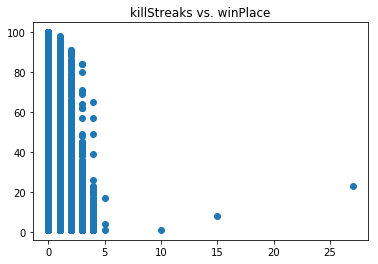

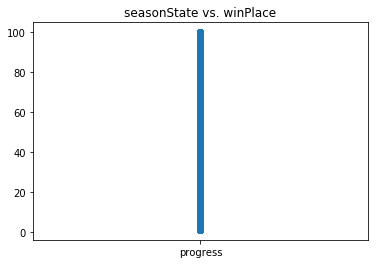

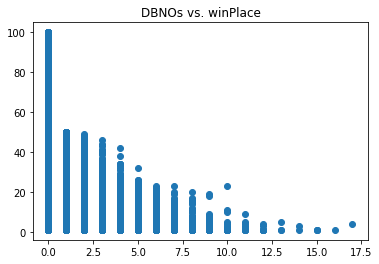

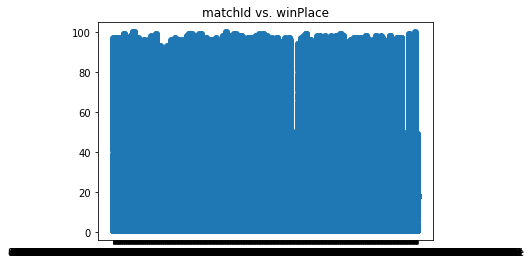

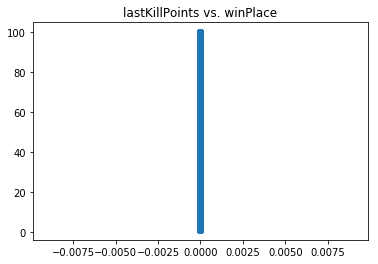

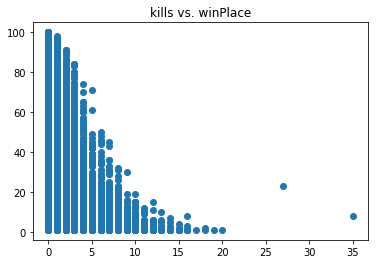

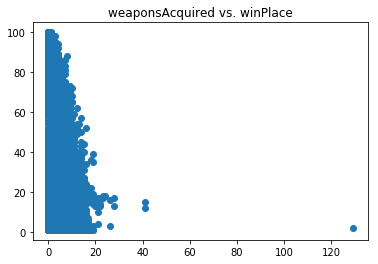

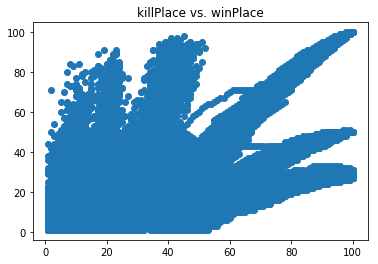

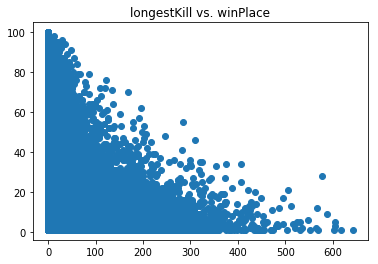

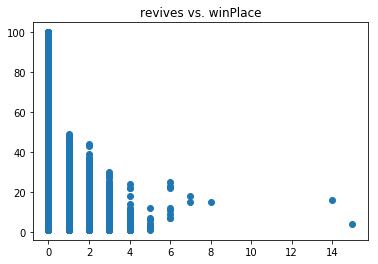

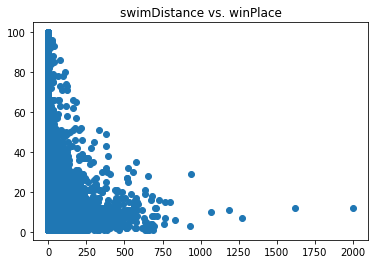

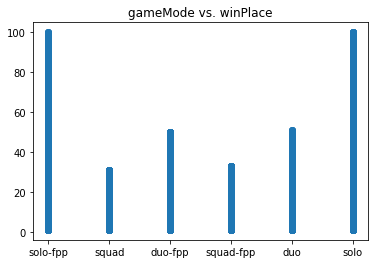

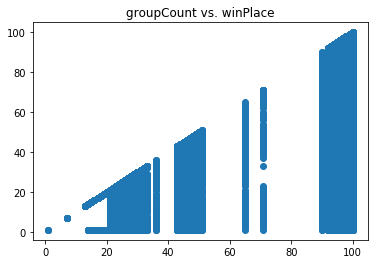

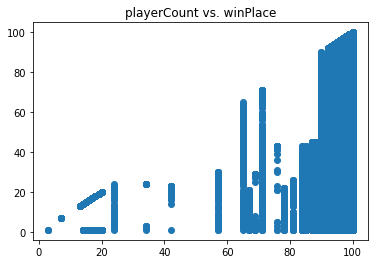

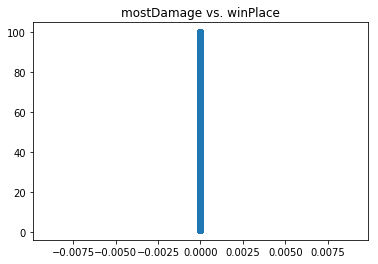

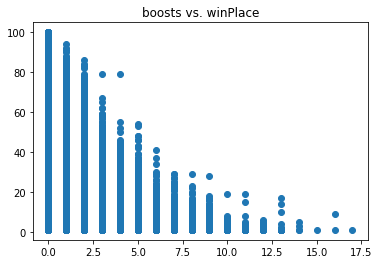

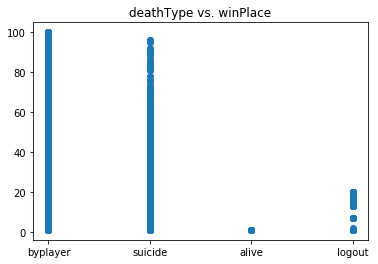

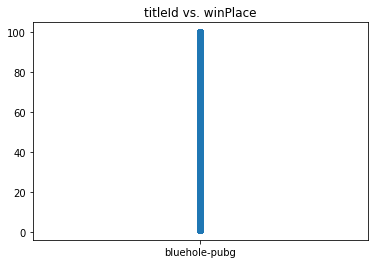

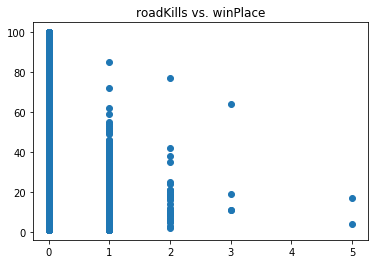

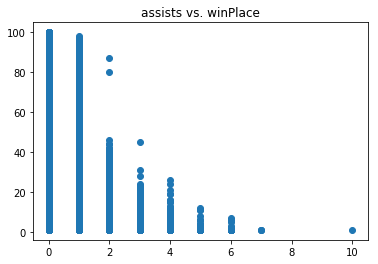

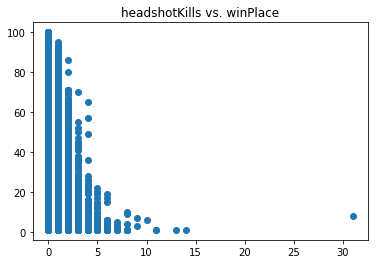

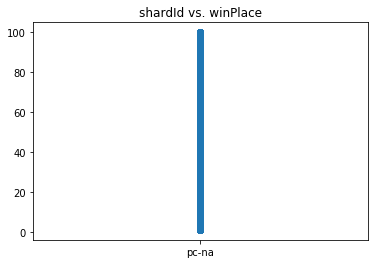

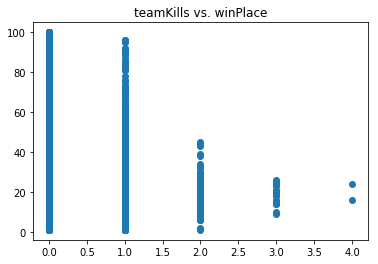

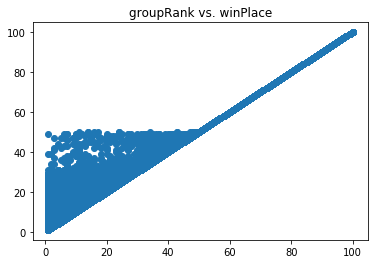

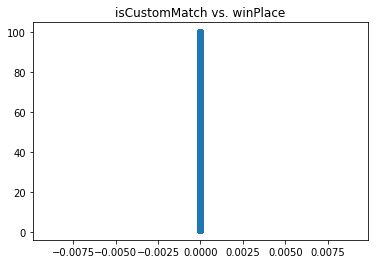

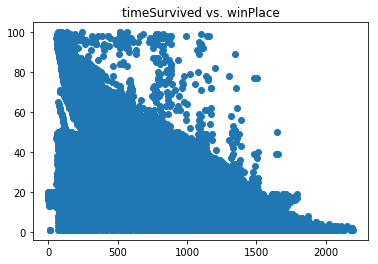

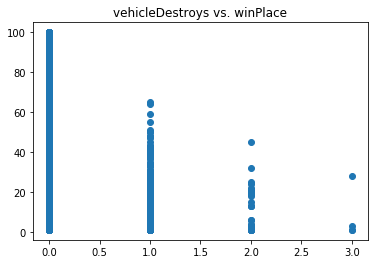

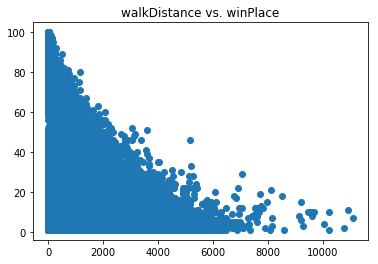

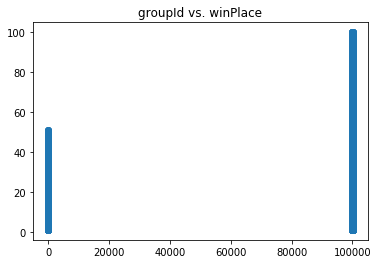

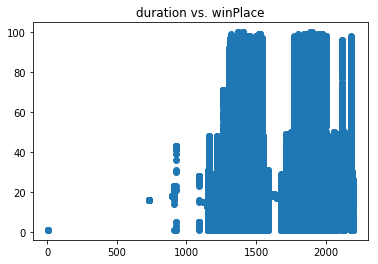

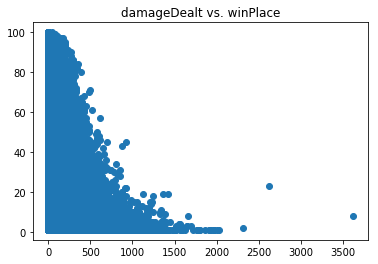

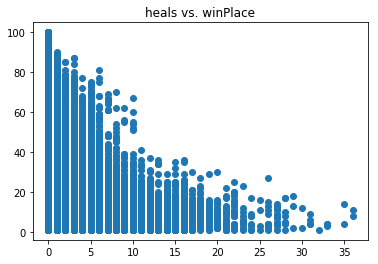

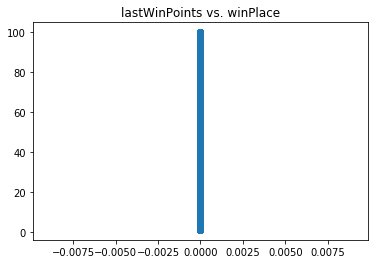

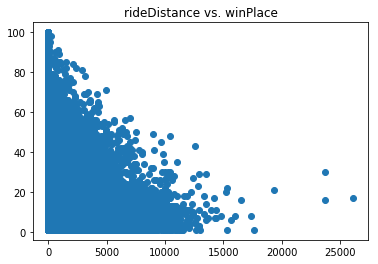

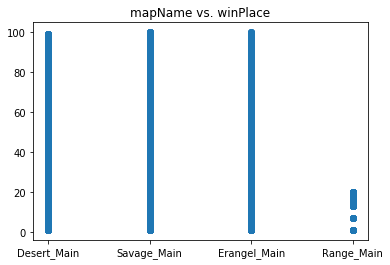

In [4]:
# Deprecated columns or not needed
useless_columns = ['id', 'killPoints', 'killPointsDelta', 'rankPoints', 'winPoints', 'winPointsDelta', 'stats', 'tags', 'createdAt', 'name', 'playerId']
# Value that we are predicting
y_column = 'winPlace'

columns = list(set(data.columns) - set(useless_columns) - set([y_column]))

for col in columns:
    fig = plt.figure()
    plt.title("{} vs. {}".format(col, y_column))
    plt.scatter(data[col], data[y_column])
    plt.savefig("figures/{}vs{}".format(col, y_column))
    plt.show(block=False)
    plt.close(fig)
    

## Visualize killPlace and duration with Categorical Labels

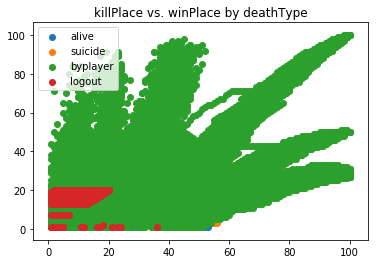

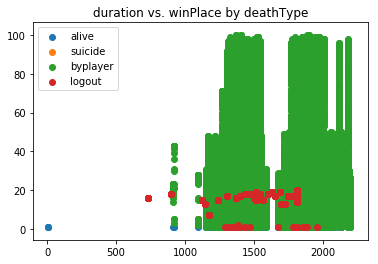

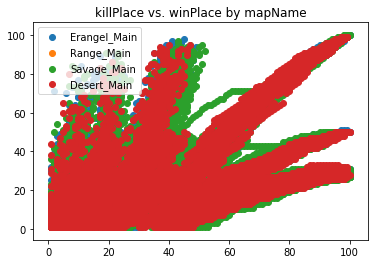

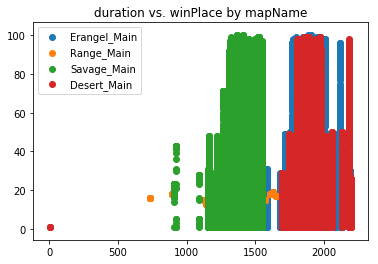

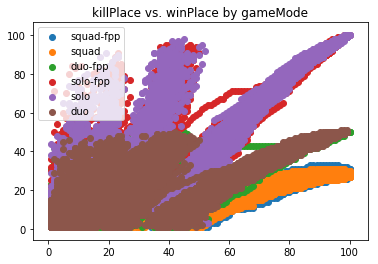

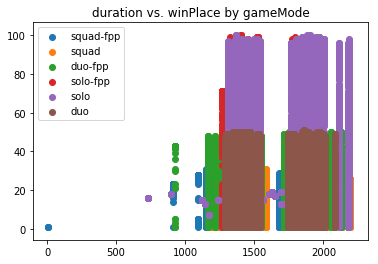

In [5]:
categorical_columns = ['deathType', 'mapName', 'gameMode']

interesting_columns = ['killPlace', 'duration']

for labelColumn in categorical_columns:
    for col in interesting_columns:
        fig = plt.figure()

        labels = list(set(data[labelColumn]))
        for label in labels:
            d = data.query('{} == "{}"'.format(labelColumn, label))
            plt.title("{} vs. {} by {}".format(col, y_column, labelColumn))
            plt.scatter(d[col], d[y_column], label=label)

        plt.legend()
        plt.savefig("figures/{}vs{}by{}".format(col, y_column, labelColumn))
        plt.show(block=False)
        plt.close(fig)

In [6]:
# Remove more columns based on lack of correlation shown in above charts
useless_columns += ['lastWinPoints', 'lastKillPoints', 'titleId', 'shardId', 'seasonState', 'isCustomMatch', 'mostDamage', 'groupRank']

## Split Sets

In [7]:
data = data.drop(columns=useless_columns)

# Grab 80% of data for training at random
train = data.sample(frac=0.8)
test = data.drop(train.index)

train_Y = train[y_column]
train_X = train.drop(columns=[y_column])

test_Y = test[y_column]
test_X = test.drop(columns=[y_column])

## Pre-processing

In [8]:
# Create subsets of columns

ordinal_columns = ['groupId', 'matchId']
# Ordinal columns are different from other_columns because they need to be encoded
other_columns = list(set(train_X.columns.values) - set(categorical_columns) - set(ordinal_columns))

In [9]:
# Vectorize categorical columns

for c in categorical_columns:
    le = LabelEncoder()
    train_X[c] = le.fit_transform(train_X[c])
    ohe = OneHotEncoder(sparse = False)
    train_X = train_X.join(pd.DataFrame(list(ohe.fit_transform(train_X.pop(c).values.reshape(-1, 1))), columns = ['{}-{}'.format(c, i) for i in ohe.active_features_], index = train_X.index))
    test_X[c] = le.transform(test_X[c])
    test_X = test_X.join(pd.DataFrame(list(ohe.transform(test_X.pop(c).values.reshape(-1, 1))), columns = ['{}-{}'.format(c, i) for i in ohe.active_features_], index = test_X.index))



/home/ubuntu/.local/share/virtualenvs/pubg-mp-PsJpXa7p/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/ubuntu/.local/share/virtualenvs/pubg-mp-PsJpXa7p/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function active_features_ is deprecated; The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)
/home/ubuntu/.local/share/virtualenvs/pubg-mp-PsJpXa7p/li

In [10]:
# Encode ids

for c in ordinal_columns:
    le = LabelEncoder()
    train_X[c] = le.fit_transform(train_X[c])
    test_X[c] = le.transform(test_X[c])

In [11]:
# Scale

for c in other_columns:
    s = MinMaxScaler()
    train_X[c] = s.fit_transform(train_X[c].values.reshape(-1, 1))
    test_X[c] = s.transform(test_X[c].values.reshape(-1, 1))

/home/ubuntu/.local/share/virtualenvs/pubg-mp-PsJpXa7p/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/.local/share/virtualenvs/pubg-mp-PsJpXa7p/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/.local/share/virtualenvs/pubg-mp-PsJpXa7p/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/.local/share/virtualenvs/pubg-mp-PsJpXa7p/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConvers

## Linear Regression

In [12]:
train_X.shape

(75444, 38)

In [13]:
lr = LinearRegression()
lr.fit(X=train_X, y=train_Y)

pred = lr.predict(test_X)

pred_test = lr.predict(train_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))
print('Train Error: {}'.format(mean_squared_error(train_Y, pred_test)))

Error: 67.59396746372609
Train Error: 66.16328059361565


## Decision Tree Regression

In [14]:
dtr = tree.DecisionTreeRegressor()
dtr.fit(X=train_X, y=train_Y)

pred = dtr.predict(test_X)

pred_test = dtr.predict(train_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))
print('Train Error: {}'.format(mean_squared_error(train_Y, pred_test)))

Error: 12.116112613329092
Train Error: 0.0


## Random Forest Regression

In [15]:
rfr = RandomForestRegressor()
rfr.fit(X=train_X, y=train_Y)

pred = rfr.predict(test_X)

pred_test = rfr.predict(train_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))
print('Train Error: {}'.format(mean_squared_error(train_Y, pred_test)))

/home/ubuntu/.local/share/virtualenvs/pubg-mp-PsJpXa7p/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Error: 6.731548698372302
Train Error: 1.187160675467897


## AdaBoost Regression

In [16]:
abr = AdaBoostRegressor(learning_rate=0.1)
abr.fit(X=train_X, y=train_Y)

pred = abr.predict(test_X)
pred_test = abr.predict(train_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))
print('Train Error: {}'.format(mean_squared_error(train_Y, pred_test)))

Error: 42.34840297403515
Train Error: 42.126059047624274


## GradientBoosting Regression

In [17]:
gbr = GradientBoostingRegressor()
gbr.fit(X=train_X, y=train_Y)

pred = gbr.predict(test_X)

pred_test = gbr.predict(train_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))
print('Train Error: {}'.format(mean_squared_error(train_Y, pred_test)))

Error: 11.678227751020918
Train Error: 10.923297700486106
